# **FriedmanDrift synthetic dataset with concept drifts.**

### Import libraries

In [238]:
import river
from river import datasets
from river import linear_model, tree
from river import drift, metrics
from river.datasets import synth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from frouros.metrics import PrequentialError
from sklearn.pipeline import Pipeline
from frouros.detectors.concept_drift.streaming.window_based.adwin import ADWIN
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.detectors.concept_drift.streaming.statistical_process_control.ddm import DDM
from frouros.detectors.concept_drift.streaming.statistical_process_control.eddm import EDDM
from frouros.detectors.concept_drift.streaming.change_detection.page_hinkley import PageHinkley


### Generate datasets

In [240]:
dataset = synth.FriedmanDrift(
    drift_type='gra',
    position=(5000, 10000),
    seed=42
)

In [241]:
for x, y in dataset.take(5):
    print(list(x.values()), y)

[0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, 0.029797219438070344] 7.6612066799391085
[0.026535969683863625, 0.1988376506866485, 0.6498844377795232, 0.5449414806032167, 0.2204406220406967, 0.5892656838759087, 0.8094304566778266, 0.006498759678061017, 0.8058192518328079, 0.6981393949882269] 8.330237325619887
[0.3402505165179919, 0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0.09274584338014791, 0.09671637683346401, 0.8474943663474598, 0.6037260313668911, 0.8071282732743802, 0.7297317866938179] 7.044929465589236
[0.3785343772083535, 0.552040631273227, 0.8294046642529949, 0.6185197523642461, 0.8617069003107772, 0.577352145256762, 0.7045718362149235, 0.045824383655662215, 0.22789827565154686, 0.28938796360210717] 18.160369621840488
[0.0797919769236275, 0.23279088636103018, 0.10100142940972912, 0.2779736031100921, 0.6356844442644002, 0.

In [242]:
# Initialize the data containers
data = []
for i, (x, y) in enumerate(dataset):
    x_values = list(x.values())
    data.append(x_values + [y])
    if i >=10000:  # Limiting to 5000 samples for simplicity
        break

In [243]:
# Define the column names
column_names = [f'x{i}' for i in range(1, len(x_values) + 1)] + ['y']

In [244]:
# Create the DataFrame
df = pd.DataFrame(data, columns=column_names)

### Split the DataFrame into train and test sets

In [552]:
train = df.iloc[:3000]
stream = df.iloc[3000:]

In [554]:
X =train.drop(columns='y').values
y = train['y'].values

## Define and fit model

#### Linear Regressor

In [249]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression()),
    ]
)


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

#### Decision Tree Regressor

In [465]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("model", DecisionTreeRegressor()),  # Use Decision Tree Regression model
    ]
)

#### RandomForest Regressor

In [557]:
pipeline_rf = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("model", RandomForestRegressor()),  # Use Random Forest Regression model
    ]
)


In [559]:
pipeline.fit(X=X, y=y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [561]:
odp=[5000]#track the actual point where drift occures.on 5000 index onwards all are in another concept

In [563]:
X =stream.drop(columns='y').values
y = stream['y'].values

In [565]:
print(y[:5])

[ 9.23990461 19.31298451 13.86472323 13.1309806  11.04805505]


In [567]:
# Detector configuration and instantiation
config = DDMConfig(
    warning_level=0.01, #These levels essentially define how many standard deviations away from the mean error are considered a warning or a drift.
    drift_level=0.5,
    min_num_instances=1000,  # minimum number of instances before checking for concept drift
)
detector = DDM(config=config)

In [569]:
detector = DDM(config=config)

In [571]:
detector=EDDM()

In [573]:
detected_drifts = []
false_alarms = 0
detection_delays = []

In [575]:
y_preds = []

In [577]:
errors = []

### Process the stream data and check for drift

In [580]:
warning_flag = False
for i in range(len(X)):
    X_i = X[i].reshape(1, -1)
    y_i = y[i].reshape(1, -1)
    
    # Predict and calculate the error
    y_pred = pipeline.predict(X_i)#here y_pred is an array resulted from pipieline
    y_preds.append(y_pred[0])
    error = mean_squared_error(y_i, y_pred)
    errors.append(error)
    
    binary_error = 1 if error > 25.0 else 0
    
    # Update DDM with the error 
    detector.update(value=binary_error)
    
    
    # Check for detected drift
    if detector.drift:
       # print(f"Change detected at step {i + len(train)}")  # Adjusting index to match the full dataset
        detected_drifts.append(i + len(train))  # Adjusting index to match the full dataset
        
        # Determine if it's a false alarm or not
        if i + len(train) < odp[0]:  # Compare with the original drift point
            false_alarms += 1
        else:
            detection_delays.append((i + len(train)) - odp[0])
    # Check for detected warning
    if not warning_flag and detector.warning:
        print(f"Warning detected at step {i}")
        warning_flag = True
        
    

Warning detected at step 437


In [581]:
print(len(errors))

7001


### Calculate metrics

In [585]:
false_alarm_rate = false_alarms / len(detected_drifts) if detected_drifts else 0
average_detection_delay = np.mean(detection_delays) if detection_delays else None

### Results

In [588]:
print(f"Detected drift points: {detected_drifts}")
print(f"False alarms: {false_alarms}")
print(f"False alarm rate: {false_alarm_rate}")
print(f"Average detection delay: {average_detection_delay}")

Detected drift points: [5066, 5067, 5070, 5073, 5074, 5078, 5083, 5084, 5087, 5090, 5098, 5105, 5107, 5108, 5109, 5110, 5112, 5113, 5120, 5122, 5128, 5130, 5134, 5135, 5136, 5140, 5147, 5149, 5152, 5154, 5165, 5169, 5170, 5171, 5173, 5187, 5194, 5196, 5198, 5200, 5202, 5203, 5205, 5206, 5208, 5210, 5211, 5212, 5214, 5217, 5222, 5224, 5226, 5227, 5228, 5232, 5233, 5235, 5242, 5248, 5252, 5254, 5255, 5262, 5268, 5269, 5271, 5272, 5278, 5282, 5283, 5292, 5296, 5299, 5302, 5310, 5313, 5314, 5315, 5316, 5317, 5318, 5320, 5322, 5326, 5329, 5332, 5336, 5337, 5338, 5341, 5344, 5346, 5349, 5355, 5360, 5361, 5368, 5369, 5370, 5371, 5374, 5376, 5378, 5382, 5384, 5385, 5388, 5390, 5391, 5395, 5407, 5408, 5412, 5413, 5417, 5418, 5420, 5421, 5422, 5424, 5425, 5433, 5435, 5436, 5437, 5439, 5443, 5444, 5446, 5449, 5454, 5456, 5460, 5461, 5463, 5464, 5465, 5472, 5476, 5479, 5488, 5489, 5490, 5492, 5493, 5495, 5500, 5501, 5502, 5507, 5508, 5510, 5511, 5512, 5517, 5523, 5527, 5530, 5532, 5533, 5534, 5542

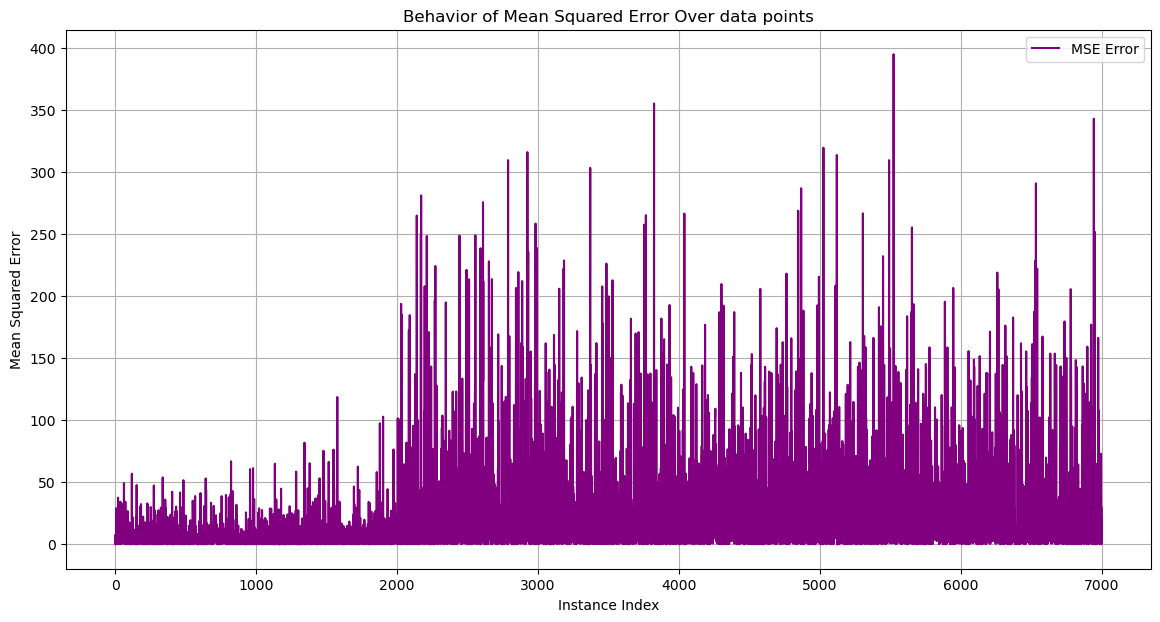

In [590]:
# Plotting the error values
plt.figure(figsize=(14, 7))
plt.plot(range(len(errors)), errors, label="MSE Error", color='purple')
plt.xlabel("Instance Index")
plt.ylabel("Mean Squared Error")
plt.title("Behavior of Mean Squared Error Over data points")
plt.legend()
plt.grid(True)
plt.show()

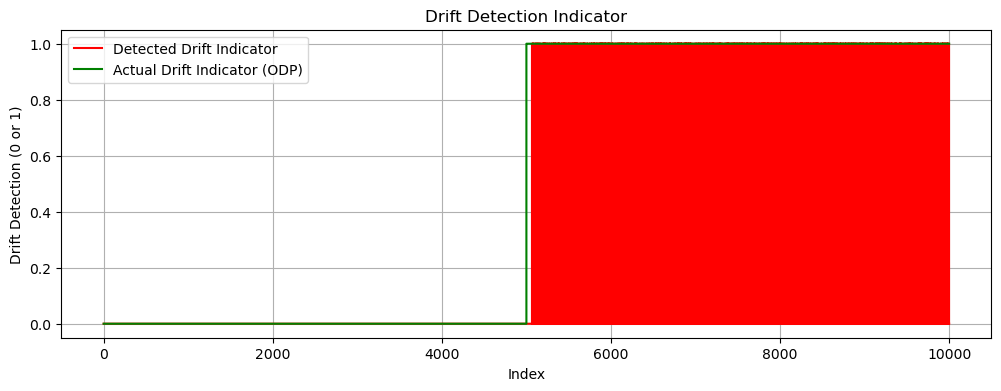

In [592]:
# Create binary arrays for drift detection and odp
drift_indicator = np.zeros(len(data))
for drift_point in detected_drifts:
    drift_indicator[drift_point] = 1

odp_indicator = np.zeros(len(data))
for i in range(odp[0], len(data)):
    odp_indicator[i] = 1

# Plotting the drift indicator and odp indicator
plt.figure(figsize=(12, 4))
plt.plot(drift_indicator, label='Detected Drift Indicator', color='red', drawstyle='steps-post')
plt.plot(odp_indicator, label='Actual Drift Indicator (ODP)', color='green', linestyle='-', drawstyle='steps-post')
plt.xlabel('Index')
plt.ylabel('Drift Detection (0 or 1)')
plt.title('Drift Detection Indicator')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()